In [1]:
! pip install transformers datasets torch

In [2]:
from transformers import AutoTokenizer, AutoModel,  Trainer, TrainingArguments
from datasets import load_dataset
import torch
import numpy as np

# Load the dataset
dataset = load_dataset('imdb')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
torch.manual_seed(1337)
dataset.save_to_disk('imdb')
dataset.shape

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50000 [00:00<?, ? examples/s]

{'train': (25000, 2), 'test': (25000, 2), 'unsupervised': (50000, 2)}

In [4]:
print(dataset['train'][0].keys())
print(dataset['test'][0].keys())
print(type(dataset['train'][0]['text']), type(dataset['train'][0]['label']))

dict_keys(['text', 'label'])
dict_keys(['text', 'label'])
<class 'str'> <class 'int'>


In [5]:
# creating training and validation datasets
train_dataset = dataset['train']
test_dataset = dataset['test']

# check for missing values
sum_missing = np.sum([1 for i in train_dataset if i['text'] == '' or i['text'] is None or i['label'] is None])
print(f'Missing values in train dataset: {sum_missing}')

sum_missing = np.sum([1 for i in test_dataset if i['text'] == '' or i['text'] is None or i['label'] is None])
print(f'Missing values in test dataset: {sum_missing}')

print(train_dataset[0]['text'][0:100])
print(train_dataset[0]['label'])

Missing values in train dataset: 0.0
Missing values in test dataset: 0.0
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w
0


In [6]:
# let's tokenize the dataset
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
distilbert_model = AutoModel.from_pretrained("distilbert/distilbert-base-uncased")

In [7]:
print(type(train_dataset))
print(type(test_dataset))

# Tokenize the dataset
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))

<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>


In [8]:
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [9]:
print(train_dataset[0].keys())
print(train_dataset[0]['text'][0:100])
print(train_dataset[0]['input_ids'][0:10])
print(train_dataset[0]['attention_mask'][0:10])

# let's see what the tokens are for first 10 input ids of the first training sample
print(tokenizer.convert_ids_to_tokens(train_dataset[0]['input_ids'][0:10]))

dict_keys(['text', 'label', 'input_ids', 'attention_mask'])
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w
[101, 1045, 12524, 1045, 2572, 8025, 1011, 3756, 2013, 2026]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['[CLS]', 'i', 'rented', 'i', 'am', 'curious', '-', 'yellow', 'from', 'my']


In [10]:
# also let's see some vocab usage statistics of the training dataset
vocab = tokenizer.get_vocab()
vocab_size = len(vocab)
print(type(vocab))
print(vocab_size)

<class 'dict'>
30522


In [11]:
all_token_ids = []
for sent in train_dataset['input_ids']:
    all_token_ids.extend(sent)

multiset = {}
for token_id in all_token_ids:
    if token_id in multiset:
        multiset[token_id] += 1
    else:
        multiset[token_id] = 1

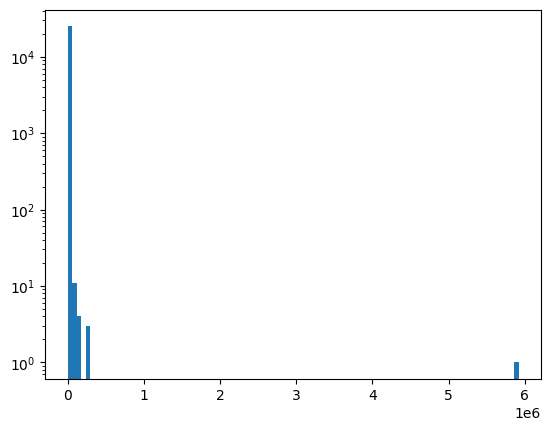

1. [PAD]: 5917414
2. the: 295578
3. .: 289768
4. ,: 239894
5. a: 144569
6. and: 144226
7. of: 127761
8. to: 118725
9. ': 115865
10. is: 95055
11. /: 93787
12. br: 88263
13. <: 88076
14. >: 87949
15. it: 85757
16. in: 83278
17. i: 80732
18. this: 69088
19. that: 64081
20. -: 57900
21. ": 57346
22. s: 54922
23. was: 43883
24. movie: 40964
25. as: 40962
26. for: 38764
27. with: 38500
28. but: 37404
29. film: 35537
30. ): 31853
31. (: 31314
32. t: 30443
33. you: 30310
34. on: 30241
35. not: 27022
36. he: 26152
37. are: 25833
38. his: 25161
39. [CLS]: 25000
40. [SEP]: 25000
41. have: 24483
42. be: 24270
43. one: 23709
44. ##s: 23405
45. !: 22092
46. all: 21204
47. at: 21052
48. they: 20007
49. by: 19799
50. an: 19420
51. who: 19113
52. so: 18829
53. like: 18073
54. from: 17951
55. there: 16551
56. her: 15949
57. just: 15698
58. or: 15697
59. about: 15506
60. out: 15139
61. has: 14883
62. if: 14688
63. what: 14295
64. ?: 14002
65. some: 13984
66. good: 13748
67. can: 13284
68. very: 12688
69

In [12]:
multiset = {k: v for k, v in sorted(multiset.items(), key=lambda item: item[1], reverse=True)}

# make a histogram of the token usage
import matplotlib.pyplot as plt

plt.hist(multiset.values(), bins=100)
plt.yscale('log')
plt.show()

# see the most used tokens

for i, (token_id, count) in enumerate(multiset.items()):
    print(f'{i+1}. {tokenizer.convert_ids_to_tokens(token_id)}: {count}')

In [13]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print(train_dataset[0].keys())
print(train_dataset[0]['input_ids'])
print(train_dataset[0]['attention_mask'])
print(train_dataset[0]['label'])

dict_keys(['label', 'input_ids', 'attention_mask'])
tensor([  101,  1045, 12524,  1045,  2572,  8025,  1011,  3756,  2013,  2026,
         2678,  3573,  2138,  1997,  2035,  1996,  6704,  2008,  5129,  2009,
         2043,  2009,  2001,  2034,  2207,  1999,  3476,  1012,  1045,  2036,
         2657,  2008,  2012,  2034,  2009,  2001,  8243,  2011,  1057,  1012,
         1055,  1012,  8205,  2065,  2009,  2412,  2699,  2000,  4607,  2023,
         2406,  1010,  3568,  2108,  1037,  5470,  1997,  3152,  2641,  1000,
         6801,  1000,  1045,  2428,  2018,  2000,  2156,  2023,  2005,  2870,
         1012,  1026,  7987,  1013,  1028,  1026,  7987,  1013,  1028,  1996,
         5436,  2003,  8857,  2105,  1037,  2402,  4467,  3689,  3076,  2315,
        14229,  2040,  4122,  2000,  4553,  2673,  2016,  2064,  2055,  2166,
         1012,  1999,  3327,  2016,  4122,  2000,  3579,  2014,  3086,  2015,
         2000,  2437,  2070,  4066,  1997,  4516,  2006,  2054,  1996,  2779,
        2543

In [14]:
# we are going to add a linear layer to distillbert model in model parameter
import torch.nn as nn
import torch.nn.functional as F

distilbert_model.config

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "distilbert/distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.48.3",
  "vocab_size": 30522
}

tensor -> B, T, C - batch size, sequence length, dim of embeddings

attention heads divide the dim of embeddings into multiple heads

then, the attention mechanism is applied to each head

then, the results are concatenated and passed through a linear laye


In [15]:
import torch.nn as nn

# Define a custom model with a classification head
class DistilBERTForSequenceClassification(nn.Module):
    def __init__(self, base_model, num_labels=2):
        super(DistilBERTForSequenceClassification, self).__init__()
        self.distilbert = base_model  # Base DistilBERT model
        self.classifier = nn.Linear(base_model.config.dim, num_labels)  # Custom linear layer

    def forward(self, input_ids, attention_mask=None):
        # Get the output from DistilBERT
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)

        # Extract the [CLS] token's embedding (first token)
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        # Pass through the custom classifier
        logits = self.classifier(cls_embedding)

        return logits

# Initialize the custom model
model = DistilBERTForSequenceClassification(distilbert_model, num_labels=2)

In [16]:
model.parameters

<bound method Module.parameters of DistilBERTForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_features=768, out_features=3072, bias=True)
            (lin2): Linear(in_features=3072, out_features=768, bias=True)
            (activation): GELUActivation()
          )
          (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        )
      )
    )
  )
  (classifier): Linear(in_features=768, out_features=2, bias=True)
)>

In [17]:
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 25000
})
Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 25000
})


In [18]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW # Optimizer
from torch.nn import CrossEntropyLoss
from tqdm import tqdm  # For progress bars

from sklearn.metrics import classification_report

torch.manual_seed(1337)

# Hyperparameters
epochs = 3
batch_size = 16
learning_rate = 2e-5

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = CrossEntropyLoss()

# Create DataLoader for training and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    # Training phase
    model.train()  # Set model to training mode
    total_train_loss = 0

    for batch in tqdm(train_dataloader, desc="Training"):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(input_ids=input_ids, attention_mask=attention_mask)

        # Compute loss
        loss = loss_fn(logits, labels)

        total_train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f'Training loss: {avg_train_loss:.4f}')

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    correct_predictions = 0

    all_labels = []
    all_preds = []
    with torch.no_grad():  # Disable gradient computation
        for batch in tqdm(test_dataloader, desc="Validation"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs

            # Compute loss
            loss = loss_fn(logits, labels)
            total_val_loss += loss.item()

            # Compute accuracy
            preds = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(preds == labels).item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate average validation loss and accuracy
    avg_val_loss = total_val_loss / len(test_dataloader)
    accuracy = correct_predictions / len(test_dataset)

    report = classification_report(all_labels, all_preds, output_dict=True)['macro avg']


    print(f'Validation loss: {avg_val_loss:.4f}')
    print(f'Validation accuracy: {accuracy:.4f}')
    print(f'Validation precision: {report["precision"]:.4f}')
    print(f'Validation recall: {report["recall"]:.4f}')
    print(f'Validation f1-score: {report["f1-score"]:.4f}')

print('Training complete!')

Epoch 1/3
----------


Training: 100%|██████████| 1563/1563 [03:57<00:00,  6.58it/s]


Training loss: 0.2479


Validation: 100%|██████████| 1563/1563 [01:16<00:00, 20.34it/s]


Validation loss: 0.1930
Validation accuracy: 0.9261
Validation precision: 0.9265
Validation recall: 0.9261
Validation f1-score: 0.9261
Epoch 2/3
----------


Training: 100%|██████████| 1563/1563 [03:57<00:00,  6.59it/s]


Training loss: 0.1351


Validation: 100%|██████████| 1563/1563 [01:16<00:00, 20.42it/s]


Validation loss: 0.1998
Validation accuracy: 0.9306
Validation precision: 0.9306
Validation recall: 0.9306
Validation f1-score: 0.9306
Epoch 3/3
----------


Training: 100%|██████████| 1563/1563 [03:56<00:00,  6.60it/s]


Training loss: 0.0710


Validation: 100%|██████████| 1563/1563 [01:16<00:00, 20.42it/s]

Validation loss: 0.2094
Validation accuracy: 0.9326
Validation precision: 0.9327
Validation recall: 0.9326
Validation f1-score: 0.9326
Training complete!
